In [1]:
import re
import datetime
import pathlib
import polars as pl # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

In [2]:
VERSION = datetime.datetime.now().strftime("%y%m%d")
print(f"Execute Date: {VERSION}")

Execute Date: 250202


## Parameters for papermill

In [3]:
foldseek_result_tsv = pathlib.Path("../test/oryza_sativa_test/foldseek_os_random_9606.tsv")
query_uniprot_idmapping_tsv = pathlib.Path("../test/oryza_sativa_test/rice_random_gene_idmapping_all.tsv")
water_result_dir_path = pathlib.Path("../test/oryza_sativa_test/result_water")
needle_result_dir_path = pathlib.Path("../test/oryza_sativa_test/result_needle")
query_gene_list_tsv_path = pathlib.Path("../test/oryza_sativa_test/rice_random_gene_idmapping_all.tsv")
togoid_convert_tsv_path = pathlib.Path("../test/oryza_sativa_test/foldseek_hit_species_togoid_convert.tsv")

In [4]:
foldseek_result_df = pl.read_csv(
    foldseek_result_tsv,
    separator='\t'
)

foldseek_result = pl.read_csv(
    query_uniprot_idmapping_tsv, # query idmapping
    separator='\t'
).join(
    foldseek_result_df,
    on="UniProt Accession",
    how="inner",
    coalesce=True
)

display(foldseek_result)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0859200""","""Q94DD0""","""Q8IUS5""",9.3810e-12,1.0,26,19.1,0.191,73,5,347,347,32,362,362,382,0.988,0.914,0.4828,0.554,0.5339,0.5339,9.701,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""SKLVLITAVALLGWAYKVA-RPPP---PPI…","""ASIHLLKLLWSLGKGPAQTFRRPAREHPP-…",219,"""0.692,0.714,0.733,0.750,0.765,…"
"""Os01g0859200""","""Q94DD0""","""Q99685""",2.3260e-11,1.0,21,17.7,0.177,56,41,337,347,19,285,303,315,0.856,0.881,0.4541,0.5321,0.5973,0.5973,5.605,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""SPRVQLKDGRHLAYREA-GVGREIAKYKII…","""LPHLVNADGQYLFCRYWKPTG--TPKALIF…",193,"""0.378,0.590,0.640,0.688,0.628,…"
"""Os01g0859200""","""Q94DD0""","""Q8TB40""",2.7890e-11,1.0,18,14.6,0.146,48,40,337,347,44,335,342,328,0.859,0.854,0.4654,0.5333,0.5402,0.5402,7.691,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""SSPRVQLKDGRHLAYREAGVGREIAK-YKI…","""LARYVSLPNQNKIWTVT--VSPEQNDRTPL…",214,"""0.167,0.320,0.679,0.700,0.797,…"
"""Os01g0859200""","""Q94DD0""","""Q9H6B9""",6.9150e-11,1.0,22,17.3,0.173,57,39,341,347,73,357,360,329,0.873,0.792,0.4855,0.541,0.5233,0.5233,7.893,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VSSPRVQLK-DGRHLAYREAGVGREIAKYK…","""GEHGFLNLKSSGLRLHYVSAG--RGNG-PL…",202,"""0.142,0.236,0.395,0.641,0.725,…"
"""Os01g0859200""","""Q94DD0""","""Q86WA6""",1.3460e-10,1.0,22,17.7,0.177,59,33,339,347,30,290,291,332,0.885,0.897,0.4727,0.4683,0.5459,0.5459,9.807,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""GPG---GPPVSSPRVQLKDGRHLAYREAGV…","""GPAAAFGTSVTSAKVAVN-GVQLHYQQTGE…",177,"""0.087,0.143,0.118,0.094,0.125,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os06g0140700""","""Q5VPE3""","""Q58F21""",0.08207,0.116,10,10.1,0.101,37,1,308,308,381,704,947,366,1.0,0.342,0.6113,0.1119,0.04709,0.04709,44.76,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MMDLGLSLGLGLASQGSLTSSTTTTSSPGA…","""VESMPLCYIKTDITETTGRENTNEASSEGN…",229,"""0.812,1.000,0.958,0.821,0.938,…"
"""Os04g0391500""","""Q01LC6""","""Q92945""",0.000021,0.949,29,12.0,0.12,60,40,470,470,144,543,711,496,0.917,0.563,0.3483,0.1517,0.1124,0.1124,38.95,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""ATVIRVDSVSSHGTLLAVV--------QVI…","""SMTEEYRVP--DGMVGLIIGRGGEQINKIQ…",275,"""0.287,0.310,0.299,0.289,0.311,…"
"""Os04g0391500""","""Q01LC6""","""O95758""",0.0005876,0.254,41,12.5,0.125,74,1,424,470,33,549,552,589,0.902,0.937,0.2553,0.1083,0.09496,0.09496,34.37,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MALTAAAASGGDAHDDEYAKLVRGMNPPRV…","""NSSTPSTANGNDSK--------------KF…",278,"""0.750,0.750,0.792,0.679,0.694,…"


&nbsp;

&nbsp;

## Create Scatter Plot for all hits (Strucutural alignment identity vs LDDT)

- Identity in the results of the structural alignment is also output in the foldseek output.
- However, in this notebook, you can also select the results of the pairwise alignment of amino acid sequences (global alignment, local alignment).

<Figure size 4000x4000 with 0 Axes>

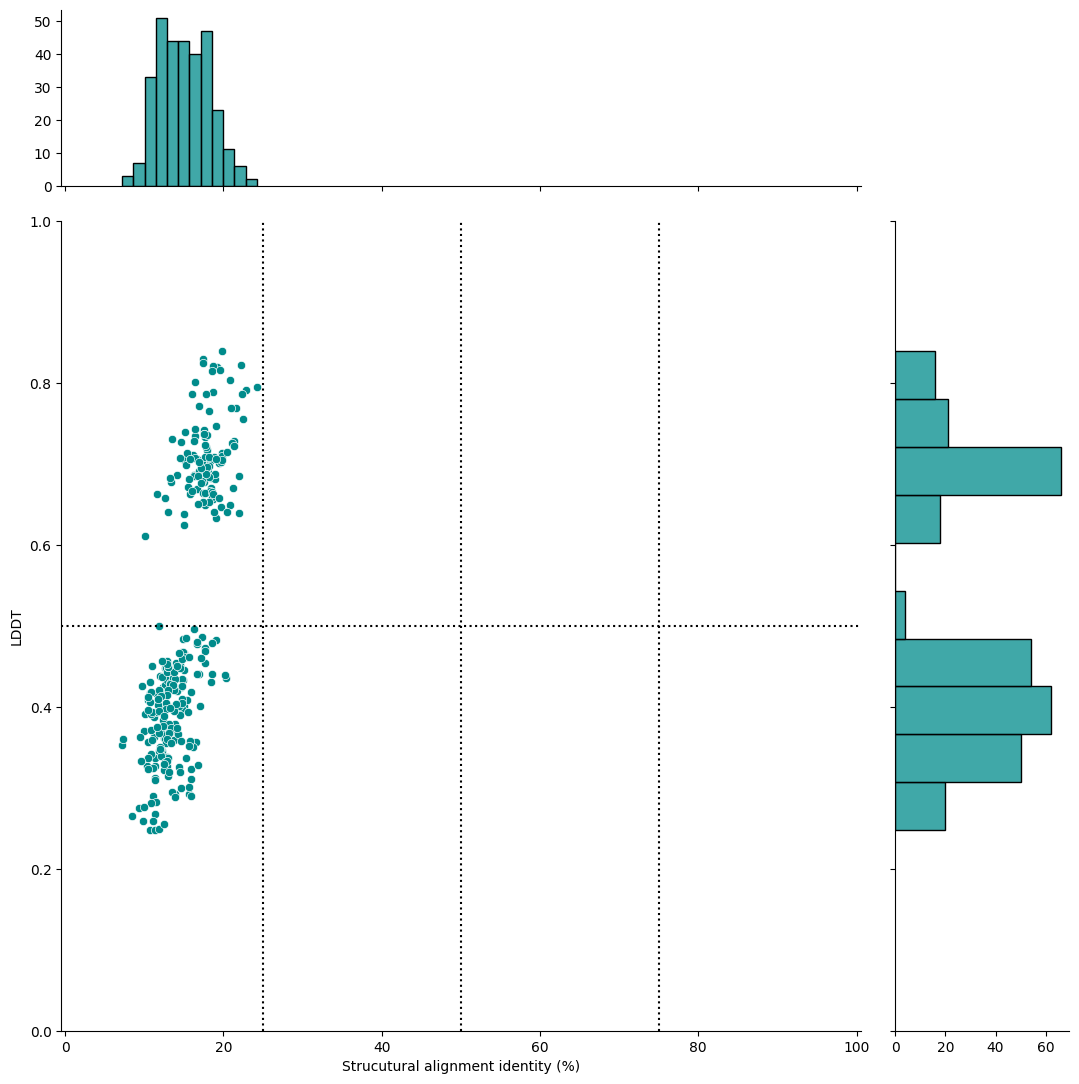

<Figure size 5000x5000 with 0 Axes>

In [5]:
foldseek_result_pd = foldseek_result.to_pandas()
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=foldseek_result_pd,
    x="pident", # Strucutural alignment identity (%) 
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)


plt.xlim(-0.5,100.5)
plt.ylim(0,1)
plt.xlabel("Strucutural alignment identity (%)")
plt.ylabel("LDDT")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

&nbsp;

&nbsp;

&nbsp;

## Parse pairwise alignment result (water and needle)

In [6]:
def parse_needle_water_result(file_path: str):
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.readlines()
        
    result = {
        "UniProt Accession": None,
        "foldseek hit": None,
        "Length": None,
        "Identity": None,
        "Identity_percent": None,
        "Similarity": None,
        "Similarity_percent": None,
        "Gaps": None,
        "Gaps_percent": None,
        "Score": None
    }
    
    for line in data:
        if line.startswith('# 1:'):
            result['UniProt Accession'] = line.split(':')[1].strip()
        elif line.startswith('# 2:'):
            result['foldseek hit'] = line.split(':')[1].strip()
        elif line.startswith('# Length:'):
            result['Length'] = int(line.split()[2])
        elif line.startswith('# Identity:'):
            result['Identity'] = line.split()[2]
            result['Identity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Similarity:'):
            result['Similarity'] = line.split()[2]
            result['Similarity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Gaps:'):
            result['Gaps'] = line.split()[2]
            result['Gaps_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Score:'):
            result['Score'] = float(line.split()[2])
            
    return result

In [7]:
water_result_dir = pathlib.Path(water_result_dir_path)
needle_result_dir = pathlib.Path(needle_result_dir_path)

# Initialize empty lists to store DataFrames
water_dfs = []
needle_dfs = []

# Collect all water results
for result_file in water_result_dir.glob("*_align.water"):
    parsed_data = parse_needle_water_result(result_file)
    water_dfs.append(pl.DataFrame([parsed_data]))

# Collect all needle results    
for result_file in needle_result_dir.glob("*_align.needle"):
    parsed_data = parse_needle_water_result(result_file)
    needle_dfs.append(pl.DataFrame([parsed_data]))

# Combine all results and sort only if there are results
water_result = (pl.concat(water_dfs, how='vertical')
                .sort(["UniProt Accession", "foldseek hit"]) 
                if water_dfs else pl.DataFrame())

needle_result = (pl.concat(needle_dfs, how='vertical')
                 .sort(["UniProt Accession", "foldseek hit"])
                 if needle_dfs else pl.DataFrame())

display(water_result)
display(needle_result)

UniProt Accession,foldseek hit,Length,Identity,Identity_percent,Similarity,Similarity_percent,Gaps,Gaps_percent,Score
str,str,i64,str,f64,str,f64,str,f64,f64
"""A0A0P0UZ77""","""P82664""",40,"""13/40""",32.5,"""19/40""",47.5,"""3/40""",7.5,28.5
"""A0A0P0VAM0""","""O75608""",135,"""31/135""",23.0,"""53/135""",39.3,"""32/135""",23.7,69.0
"""A0A0P0VAM0""","""O95372""",162,"""39/162""",24.1,"""63/162""",38.9,"""52/162""",32.1,91.5
"""A0A0P0VAM0""","""O95870""",67,"""17/67""",25.4,"""32/67""",47.8,"""4/67""",6.0,51.0
"""A0A0P0VAM0""","""P07098""",420,"""86/420""",20.5,"""139/420""",33.1,"""155/420""",36.9,67.5
…,…,…,…,…,…,…,…,…,…
"""Q94DD0""","""Q9ULP0""",138,"""30/138""",21.7,"""52/138""",37.7,"""39/138""",28.3,53.5
"""Q94DD0""","""Q9UMR5""",258,"""46/258""",17.8,"""81/258""",31.4,"""106/258""",41.1,38.5
"""Q94DD0""","""Q9UN36""",178,"""39/178""",21.9,"""65/178""",36.5,"""54/178""",30.3,65.0


UniProt Accession,foldseek hit,Length,Identity,Identity_percent,Similarity,Similarity_percent,Gaps,Gaps_percent,Score
str,str,i64,str,f64,str,f64,str,f64,f64
"""A0A0P0UZ77""","""P82664""",418,"""7/418""",1.7,"""8/418""",1.9,"""399/418""",95.5,7.5
"""A0A0P0VAM0""","""O75608""",380,"""57/380""",15.0,"""96/380""",25.3,"""183/380""",48.2,50.0
"""A0A0P0VAM0""","""O95372""",388,"""64/388""",16.5,"""101/388""",26.0,"""198/388""",51.0,71.0
"""A0A0P0VAM0""","""O95870""",639,"""77/639""",12.1,"""125/639""",19.6,"""373/639""",58.4,19.5
"""A0A0P0VAM0""","""P07098""",460,"""92/460""",20.0,"""150/460""",32.6,"""175/460""",38.0,65.0
…,…,…,…,…,…,…,…,…,…
"""Q94DD0""","""Q9ULP0""",668,"""10/668""",1.5,"""12/668""",1.8,"""637/668""",95.4,18.0
"""Q94DD0""","""Q9UMR5""",425,"""60/425""",14.1,"""109/425""",25.6,"""201/425""",47.3,21.5
"""Q94DD0""","""Q9UN36""",560,"""45/560""",8.0,"""79/560""",14.1,"""402/560""",71.8,38.5


In [8]:
alignment_result = water_result.join(
    needle_result,
    on=["UniProt Accession", "foldseek hit"],
    how="inner",
    coalesce=True,
    suffix="_needle"
).rename(
    {
        "Length": "Length_water",
        "Identity": "Identity_water",
        "Identity_percent": "Identity_percent_water",
        "Similarity": "Similarity_water",
        "Similarity_percent": "Similarity_percent_water",
        "Gaps": "Gaps_water",
        "Gaps_percent": "Gaps_percent_water",
        "Score": "Score_water"
    }
).select(
    [
        "UniProt Accession",
        "foldseek hit",
        "Length_water",
        "Length_needle",
        "Identity_water",
        "Identity_needle",
        "Identity_percent_water",
        "Identity_percent_needle",
        "Similarity_percent_water",
        "Similarity_percent_needle",
        "Gaps_water",
        "Gaps_needle",
        "Gaps_percent_water",
        "Gaps_percent_needle",
        "Score_water",
        "Score_needle"
    ]
)

display(alignment_result)

UniProt Accession,foldseek hit,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""A0A0P0UZ77""","""P82664""",40,418,"""13/40""","""7/418""",32.5,1.7,47.5,1.9,"""3/40""","""399/418""",7.5,95.5,28.5,7.5
"""A0A0P0VAM0""","""O75608""",135,380,"""31/135""","""57/380""",23.0,15.0,39.3,25.3,"""32/135""","""183/380""",23.7,48.2,69.0,50.0
"""A0A0P0VAM0""","""O95372""",162,388,"""39/162""","""64/388""",24.1,16.5,38.9,26.0,"""52/162""","""198/388""",32.1,51.0,91.5,71.0
"""A0A0P0VAM0""","""O95870""",67,639,"""17/67""","""77/639""",25.4,12.1,47.8,19.6,"""4/67""","""373/639""",6.0,58.4,51.0,19.5
"""A0A0P0VAM0""","""P07098""",420,460,"""86/420""","""92/460""",20.5,20.0,33.1,32.6,"""155/420""","""175/460""",36.9,38.0,67.5,65.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q94DD0""","""Q9ULP0""",138,668,"""30/138""","""10/668""",21.7,1.5,37.7,1.8,"""39/138""","""637/668""",28.3,95.4,53.5,18.0
"""Q94DD0""","""Q9UMR5""",258,425,"""46/258""","""60/425""",17.8,14.1,31.4,25.6,"""106/258""","""201/425""",41.1,47.3,38.5,21.5
"""Q94DD0""","""Q9UN36""",178,560,"""39/178""","""45/560""",21.9,8.0,36.5,14.1,"""54/178""","""402/560""",30.3,71.8,65.0,38.5


&nbsp;


&nbsp;

## Integrate foldseek result and pairwise alignment result

- This time, **exclude the ones that are null in pairwise alignment result, which means the current UniProt entry is obsolete**

In [9]:
join_foldseek = foldseek_result.join(
    alignment_result,
    on=["UniProt Accession", "foldseek hit"],
    how="left",
    coalesce=True
).filter( # filter out null alignment result (this means current UniProt entry is obsolete)
    pl.col("Length_water").is_not_null() & 
    pl.col("Length_needle").is_not_null()
).unique()


print(join_foldseek.group_by(["UniProt Accession", "foldseek hit"], maintain_order=True).n_unique())
display(join_foldseek.head())

shape: (307, 44)
┌─────────────┬────────────┬──────┬────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ UniProt     ┆ foldseek   ┆ From ┆ evalue ┆ … ┆ Gaps_perce ┆ Gaps_perce ┆ Score_wate ┆ Score_need │
│ Accession   ┆ hit        ┆ ---  ┆ ---    ┆   ┆ nt_water   ┆ nt_needle  ┆ r          ┆ le         │
│ ---         ┆ ---        ┆ u32  ┆ u32    ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ str         ┆ str        ┆      ┆        ┆   ┆ u32        ┆ u32        ┆ u32        ┆ u32        │
╞═════════════╪════════════╪══════╪════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ Q5VPE3      ┆ P50222     ┆ 1    ┆ 1      ┆ … ┆ 1          ┆ 1          ┆ 1          ┆ 1          │
│ Q5VPE3      ┆ Q3C1V8     ┆ 1    ┆ 1      ┆ … ┆ 1          ┆ 1          ┆ 1          ┆ 1          │
│ Q94DD0      ┆ P54317     ┆ 1    ┆ 1      ┆ … ┆ 1          ┆ 1          ┆ 1          ┆ 1          │
│ Q94DD0      ┆ Q86WA6     ┆ 1    ┆ 1      ┆ … ┆ 1          ┆ 1          ┆

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os06g0140700""","""Q5VPE3""","""P50222""",0.0005797,0.988,6,20.4,0.204,53,3,250,308,93,302,304,259,0.805,0.691,0.7144,0.1924,0.1949,0.1949,30.68,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""DLGLSLGLGLASQGSLTSSTTTTSSPGAGS…","""HLPQMSSPPSAARHSLCLQPDSGGPPELGS…",146,"""0.542,0.643,0.625,0.719,0.844,…",224,416,"""58/224""","""62/416""",25.9,14.9,39.7,23.6,"""51/224""","""220/416""",22.8,52.9,137.5,125.5
"""Os06g0140700""","""Q5VPE3""","""Q3C1V8""",0.006247,0.9,6,21.2,0.212,46,62,268,308,51,232,233,216,0.672,0.781,0.6699,0.1713,0.2235,0.2235,30.59,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VGVGGEEMYQGRASTSPDSAAALSSASGKR…","""LLDYGYPLMPTPTLLAPHAHHPLHKGDHHH…",127,"""0.231,0.312,0.409,0.550,0.778,…",113,324,"""34/113""","""59/324""",30.1,18.2,41.6,28.7,"""28/113""","""107/324""",24.8,33.0,105.5,87.0
"""Os01g0859200""","""Q94DD0""","""P54317""",0.02901,0.855,6,16.2,0.162,21,57,167,347,81,197,469,129,0.32,0.249,0.3504,0.2126,0.163,0.163,5.88,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""AGVGREIAKYKIIFSHGFASTKESDFP--V…","""SNFQLD-RKTRFII-HGFLDKAEDSWPSDM…",78,"""0.114,0.170,0.318,0.478,0.348,…",211,544,"""45/211""","""74/544""",21.3,13.6,34.6,21.7,"""45/211""","""272/544""",21.3,50.0,58.5,31.5
"""Os01g0859200""","""Q94DD0""","""Q86WA6""",1.3460e-10,1.0,22,17.7,0.177,59,33,339,347,30,290,291,332,0.885,0.897,0.4727,0.4683,0.5459,0.5459,9.807,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""GPG---GPPVSSPRVQLKDGRHLAYREAGV…","""GPAAAFGTSVTSAKVAVN-GVQLHYQQTGE…",177,"""0.087,0.143,0.118,0.094,0.125,…",305,375,"""67/305""","""75/375""",22.0,20.0,37.0,33.9,"""77/305""","""112/375""",25.2,29.9,88.0,76.0
"""Os01g0859200""","""Q94DD0""","""Q49AJ0""",0.08118,0.254,20,11.1,0.111,31,55,302,347,1129,1325,1406,277,0.715,0.14,0.2902,0.2617,0.07881,0.07881,12.25,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""REAGVGREIAKYKIIFSHGFASTKESDFPV…","""EEEEENLEDGIHLVVCVHGLDGN-SADL--…",137,"""0.058,0.075,0.109,0.133,0.176,…",55,1571,"""16/55""","""50/1571""",29.1,3.2,45.5,5.7,"""11/55""","""1389/1571""",20.0,88.4,48.0,25.0


&nbsp;

&nbsp;

## Create Scatter Plot for all hits (sequence alignment info vs LDDT)

<Figure size 4000x4000 with 0 Axes>

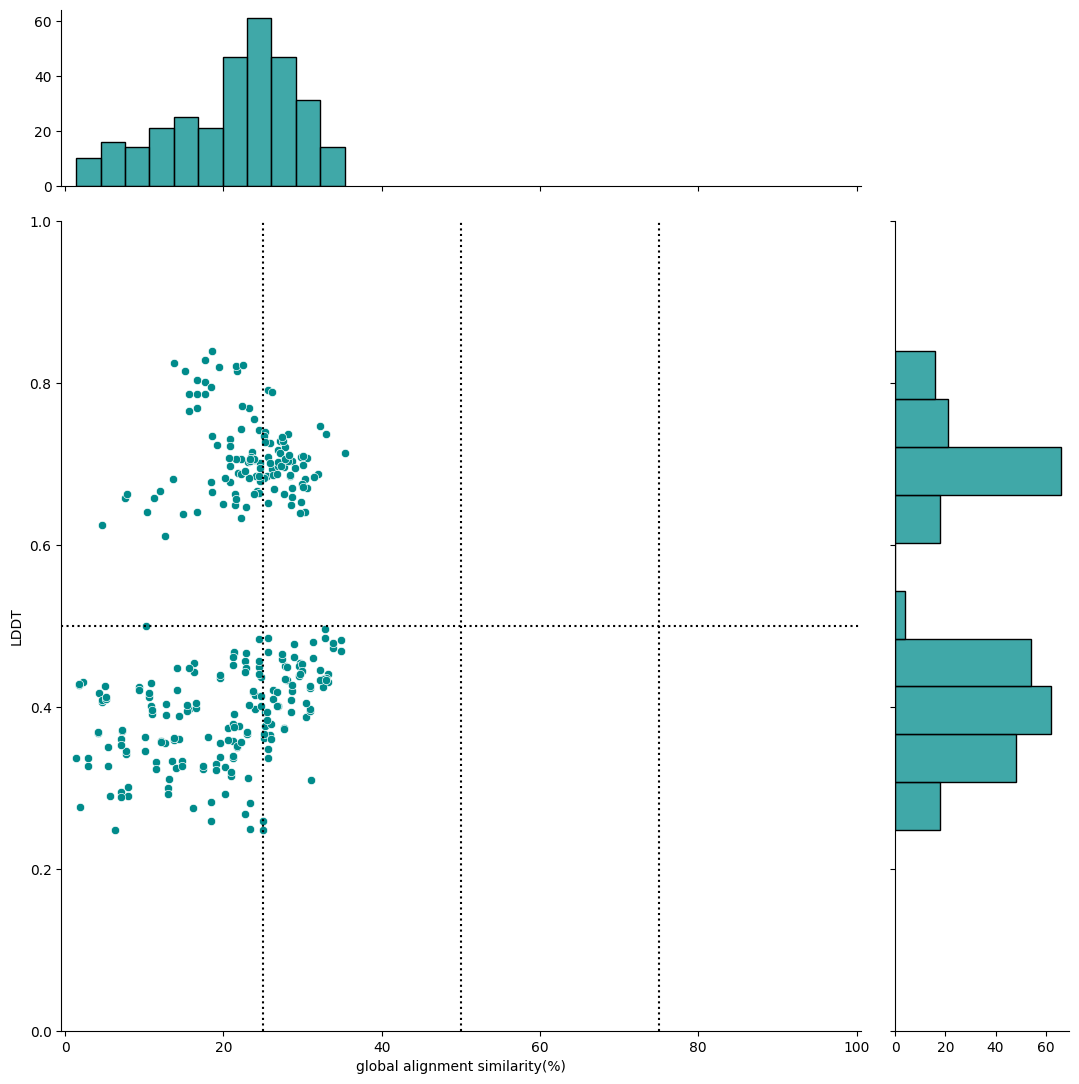

<Figure size 5000x5000 with 0 Axes>

In [10]:
join_foldseek_pd = join_foldseek.to_pandas()
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=join_foldseek_pd,
    x="Similarity_percent_needle", # You can also use Identity_percent_water, Similarity_percent_needle, Similarity_percent_water
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

# highlight the region of interest
# plt.fill_betweenx(
#     y=[0.5, 1],
#     x1=-0.5,
#     x2=25,
#     color="red",
#     alpha=0.1
# )

plt.xlim(-0.5,100.5)
plt.ylim(0,1)
plt.xlabel("global alignment similarity(%)")
plt.ylabel("LDDT")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

&nbsp;

&nbsp;

&nbsp;


# Caution:
- The filtering steps that are executed below can be changed freely.

&nbsp;

## Filtering Condition1

- Select the ones that have foldseek hit

In [11]:
all_gene_list = pl.read_csv(
    query_gene_list_tsv_path,
    separator='\t'
).select(
    "From"
).unique()

hit_count = all_gene_list.join(
    join_foldseek,
    on="From",
    how="left",
    coalesce=True
).group_by("From", maintain_order=True).agg(
    (pl.col("foldseek hit").count().alias("target hit count (gene level vs uniprot accession)")),
    (pl.col("foldseek hit").is_null().all().alias("foldseek no hit"))
).sort(
    ["target hit count (gene level vs uniprot accession)"], descending=True
)

display(hit_count)

From,target hit count (gene level vs uniprot accession),foldseek no hit
str,u32,bool
"""Os01g0859200""",168,false
"""Os06g0140700""",121,false
"""Os04g0391500""",17,false
"""Os01g0187600""",1,false
"""Os05g0352750""",0,true
"""Os12g0129300""",0,true
"""Os01g0795250""",0,true
"""Os05g0468600""",0,true
"""Os12g0159500""",0,true


### Filter out the ones that have no foldseek hit

In [12]:
no_hit_genes_list = hit_count.filter(
    pl.col("foldseek no hit") == True
)

idmapping_list = pl.read_csv(
    query_uniprot_idmapping_tsv,
    separator='\t'
)
  
no_hit_idmapping_list = no_hit_genes_list.join(
    idmapping_list,
    on="From",
    how="left"
).sort(
    by=["From"],
    descending=[False]
)

print(no_hit_idmapping_list.group_by(["From"], maintain_order=True).n_unique())
display(no_hit_idmapping_list.head())

shape: (6, 4)
┌──────────────┬─────────────────────────────────┬─────────────────┬───────────────────┐
│ From         ┆ target hit count (gene level v… ┆ foldseek no hit ┆ UniProt Accession │
│ ---          ┆ ---                             ┆ ---             ┆ ---               │
│ str          ┆ u32                             ┆ u32             ┆ u32               │
╞══════════════╪═════════════════════════════════╪═════════════════╪═══════════════════╡
│ Os01g0795250 ┆ 1                               ┆ 1               ┆ 1                 │
│ Os02g0609000 ┆ 1                               ┆ 1               ┆ 2                 │
│ Os05g0352750 ┆ 1                               ┆ 1               ┆ 1                 │
│ Os05g0468600 ┆ 1                               ┆ 1               ┆ 1                 │
│ Os12g0129300 ┆ 1                               ┆ 1               ┆ 2                 │
│ Os12g0159500 ┆ 1                               ┆ 1               ┆ 3                 │
└──────

From,target hit count (gene level vs uniprot accession),foldseek no hit,UniProt Accession
str,u32,bool,str
"""Os01g0795250""",0,true,"""A0A0P0V975"""
"""Os02g0609000""",0,true,"""B9F105"""
"""Os02g0609000""",0,true,"""Q6K1X4"""
"""Os05g0352750""",0,true,"""A0A0N7KKL4"""
"""Os05g0468600""",0,true,"""A0A0P0WNJ6"""


&nbsp;

&nbsp;

## Filtering Condition2

In [13]:
condition2 = join_foldseek.sort(
    by=["qcov", "foldseek hit", "lddt"], # sort by qcov, foldseek hit, lddt
    descending=[True, False, True]
).group_by(
    ["From", "foldseek hit"],
    maintain_order=True
).agg(
    [
        pl.all().first() # sustain the first record in each group (in this case, qcov is the highest and lddt is the highest)
    ]
).sort(
    by=["From", "UniProt Accession", "foldseek hit"],
    descending=[False, False, False],
    maintain_order=True
)

print(condition2.group_by(["From"], maintain_order=True).n_unique())
display(condition2)

shape: (4, 44)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ foldseek   ┆ UniProt   ┆ evalue ┆ … ┆ Gaps_perc ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ hit        ┆ Accession ┆ ---    ┆   ┆ ent_water ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---       ┆ u32    ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ u32        ┆ u32       ┆        ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆           ┆        ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os01g01876 ┆ 1          ┆ 1         ┆ 1      ┆ … ┆ 1         ┆ 1         ┆ 1         ┆ 1         │
│ 00         ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆           │
│ Os01g08592 ┆ 89         ┆ 2         ┆ 86     ┆ … ┆ 82        ┆ 80        ┆

From,foldseek hit,UniProt Accession,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os01g0187600""","""P82664""","""A0A0P0UZ77""",0.01979,0.15,12,9.9,0.099,20,9,187,236,38,199,201,201,0.758,0.806,0.2763,0.1732,0.1954,0.1954,24.54,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""ETVTCSKAVNSDLFDAVLGGLGQFGVITRA…","""LSTNMKWVQFSNLHVDVPKDL----TKPVV…",120,"""0.152,0.167,0.157,0.154,0.171,…",40,418,"""13/40""","""7/418""",32.5,1.7,47.5,1.9,"""3/40""","""399/418""",7.5,95.5,28.5,7.5
"""Os01g0859200""","""O95870""","""A0A0P0VAM0""",0.000098,0.991,21,13.4,0.134,47,43,322,347,254,543,558,350,0.807,0.52,0.3557,0.3232,0.2119,0.2119,18.28,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""RVQLKDGRHLAYREAGVGREIAK-----YK…","""KLLACDGNEIDTMF--VDRRGTAEPQGQKL…",173,"""0.602,0.644,0.591,0.543,0.516,…",67,639,"""17/67""","""77/639""",25.4,12.1,47.8,19.6,"""4/67""","""373/639""",6.0,58.4,51.0,19.5
"""Os01g0859200""","""P07098""","""A0A0P0VAM0""",9.7090e-10,1.0,23,13.9,0.139,51,40,337,347,47,388,398,366,0.859,0.859,0.4341,0.5134,0.4581,0.4581,7.891,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""SSPRVQLKDGRHLAYRE--------AGVGR…","""EEYEVVTEDGYILEVNRIPYGKKNSGNTGQ…",223,"""0.209,0.327,0.553,0.668,0.745,…",420,460,"""86/420""","""92/460""",20.5,20.0,33.1,32.6,"""155/420""","""175/460""",36.9,38.0,67.5,65.0
"""Os01g0859200""","""P07099""","""A0A0P0VAM0""",0.000002,1.0,21,12.2,0.122,43,43,336,347,117,447,455,352,0.847,0.727,0.4568,0.5356,0.4248,0.4248,7.628,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""RVQLKDGRHLAYREAG---VGREIAKYKII…","""KTKI-EGLDIHFIHVKPPQLPAGHTPKPLL…",230,"""0.633,0.628,0.665,0.750,0.610,…",396,565,"""73/396""","""80/565""",18.4,14.2,29.3,22.7,"""192/396""","""328/565""",48.5,58.1,90.5,71.5
"""Os01g0859200""","""P10619""","""A0A0P0VAM0""",0.000002,1.0,31,12.8,0.128,63,7,344,347,11,479,480,492,0.974,0.977,0.4143,0.5182,0.3906,0.3906,19.73,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""LVLITAVALLGWAYKVARPP------PPPI…","""LLLLLLLLLVSWASRGEAAPDQDEIQRLP-…",252,"""0.600,0.625,0.647,0.667,0.681,…",254,559,"""51/254""","""77/559""",20.1,13.8,34.3,24.0,"""80/254""","""291/559""",31.5,52.1,72.0,53.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os06g0140700""","""Q9NZR4""","""Q5VPE3""",0.0007067,0.941,9,17.8,0.178,60,1,307,308,73,352,365,337,0.997,0.767,0.7205,0.1776,0.1509,0.1509,36.19,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MMDLGLSLGLGLASQGSLTSSTTTTSSPGA…","""LARGALPLGLGLLCGFGTQPPAAARAPCLL…",190,"""0.812,0.900,0.875,0.929,0.938,…",208,431,"""49/208""","""73/431""",23.6,16.9,37.5,27.8,"""45/208""","""189/431""",21.6,43.9,100.5,82.0
"""Os06g0140700""","""Q9UD57""","""Q5VPE3""",0.00105,0.933,9,17.5,0.175,59,1,308,308,48,302,310,337,1.0,0.823,0.7367,0.1788,0.1777,0.1777,42.01,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MMDLGLSLGLGLASQGSLTS-STTTTSSPG…","""KSLAEVEAGKDASSRDPVRQLETPDAAGPG…",167,"""0.812,0.900,0.875,0.893,0.906,…",284,384,"""70/284""","""74/384""",24.6,19.3,33.8,28.1,"""83/284""","""150/384""",29.2,39.1,133.0,111.5
"""Os06g0140700""","""Q9UIW0""","""Q5VPE3""",0.0001356,0.999,4,17.6,0.176,50,62,308,308,16,290,290,283,0.802,0.948,0.7328,0.2492,0.2632,0.2632,27.37,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VGVGGEEMYQGRASTSPDSAAALSSASGKR…","""AESGGGGGRCGDRSGAGDLRADGGGHSPTE…",189,"""0.269,0.417,0.523,0.675,0.778,…",2

&nbsp;

&nbsp;

## Filtering Condition3

- select the ones with qcov (query coverage) >= 0.5 and tcov (target coverage) >= 0.5

In [14]:
condition3 = condition2.filter(
        (pl.col("qcov") >= 0.5) &
        (pl.col("tcov") >= 0.5)
    ).unique()

condition3_rm = condition2.filter(
        (pl.col("qcov") < 0.5) |
        (pl.col("tcov") < 0.5)
    )

print(condition3.group_by(["From"], maintain_order=True).n_unique())
display(condition3)

shape: (4, 44)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ foldseek   ┆ UniProt   ┆ evalue ┆ … ┆ Gaps_perc ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ hit        ┆ Accession ┆ ---    ┆   ┆ ent_water ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---       ┆ u32    ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ u32        ┆ u32       ┆        ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆           ┆        ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os06g01407 ┆ 98         ┆ 1         ┆ 72     ┆ … ┆ 79        ┆ 85        ┆ 70        ┆ 72        │
│ 00         ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆           │
│ Os01g08592 ┆ 61         ┆ 2         ┆ 59     ┆ … ┆ 59        ┆ 56        ┆

From,foldseek hit,UniProt Accession,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os06g0140700""","""P50221""","""Q5VPE3""",0.0001269,1.0,2,19.2,0.192,34,1,172,308,81,231,254,177,0.558,0.594,0.8194,0.1744,0.2114,0.2114,28.48,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MMDLGLSLGLGLASQGSLTSSTTTTSSPGA…","""FTEQHPAFPQSPNWHFPVSDARRRPNSGPA…",112,"""0.875,1.000,0.958,0.929,0.844,…",150,371,"""39/150""","""49/371""",26.0,13.2,38.7,19.4,"""9/150""","""180/371""",6.0,48.5,119.5,95.0
"""Os06g0140700""","""P49639""","""Q5VPE3""",0.0424,0.473,8,15.8,0.158,46,2,263,308,119,334,335,290,0.851,0.645,0.7063,0.176,0.163,0.163,43.11,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MDLGLSLGLGLASQGSLTSSTTTTSSPGAG…","""VSGGYPQCAPAVYSGNLSSPMVQHHHHHQG…",142,"""0.650,0.792,0.750,0.844,0.844,…",154,430,"""40/154""","""59/430""",26.0,13.7,42.9,23.3,"""13/154""","""217/430""",8.4,50.5,98.0,85.5
"""Os06g0140700""","""Q8TE12""","""Q5VPE3""",0.0004452,0.988,3,18.2,0.182,40,85,295,308,164,366,382,219,0.685,0.531,0.6975,0.1632,0.1327,0.1327,35.57,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""SSASGKRERELERSGSGVDDDDGADGAGGR…","""DSGKSDDEESLCKSAHGAGKGTAEEGKDHK…",155,"""0.469,0.500,0.656,0.750,0.844,…",227,472,"""51/227""","""59/472""",22.5,12.5,36.6,20.8,"""62/227""","""254/472""",27.3,53.8,112.5,76.5
"""Os01g0859200""","""Q9NQE7""","""A0A0P0VAM0""",0.002514,0.692,26,14.6,0.146,49,33,310,347,50,343,514,335,0.801,0.572,0.3001,0.2808,0.1976,0.1976,17.9,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""GPGGPPVSS---PRV-QL-----KDG---R…","""GPG--AAALPKVGWLEQLLDPFNVSDRRSF…",188,"""0.198,0.179,0.103,0.106,0.119,…",91,678,"""23/91""","""58/678""",25.3,8.6,39.6,13.0,"""25/91""","""495/678""",27.5,73.0,43.0,20.5
"""Os01g0859200""","""P10619""","""A0A0P0VAM0""",0.000002,1.0,31,12.8,0.128,63,7,344,347,11,479,480,492,0.974,0.977,0.4143,0.5182,0.3906,0.3906,19.73,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""LVLITAVALLGWAYKVARPP------PPPI…","""LLLLLLLLLVSWASRGEAAPDQDEIQRLP-…",252,"""0.600,0.625,0.647,0.667,0.681,…",254,559,"""51/254""","""77/559""",20.1,13.8,34.3,24.0,"""80/254""","""291/559""",31.5,52.1,72.0,53.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os01g0859200""","""Q5EB52""","""Q94DD0""",7.3290e-10,1.0,23,16.6,0.166,61,1,332,347,1,324,335,367,0.957,0.967,0.4771,0.5273,0.5441,0.5441,8.791,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MVALSKL---------VLITAVALLGWAYK…","""MVRRDRLRRMREWWVQVGLLAVPLLAAYLH…",228,"""0.750,0.600,0.545,0.500,0.462,…",159,418,"""38/159""","""74/418""",23.9,17.7,39.6,28.9,"""29/159""","""154/418""",18.2,36.8,46.0,28.0
"""Os04g0391500""","""Q92945""","""Q0JDM8""",0.000033,0.949,31,11.2,0.112,60,1,467,470,128,551,711,540,0.994,0.596,0.3621,0.1496,0.1112,0.1112,37.56,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MALTAAAASGGDAHDDEYAKLVRGMNPPR-…","""DSISSQLGPIHP--------------PPRT…",291,"""0.875,0.800,0.875,0.750,0.778,…",313,951,"""58/313""","""59/951""",18.5,6.2,29.7,10.1,"""89/313""","""721/951""",28.4,75.8,64.5,51.0
"""Os01g0859200""","""Q96I13""","""A0A0P0VAM0""",3.0020e-8,1.0,14,15.9,0.159,48,57,345,347,167,421,439,301,0.833,0.581,0.4178,0.4311,0.3552,0.3552,8.388,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""AGVGREIAKYKIIFSHGFASTKESDFPVSQ…","""TSCKGAQADVVLFFIHGVGGSLAI-WKEQL…",195,"""0.130,0.191,0.301,0.477,0.314,…",397,51

&nbsp;

&nbsp;


## Filtering Condition4

- select the ones that can be converted to HGNC Gene symbol through Ensembl ID by TogoID
- Article: [TogoID: an exploratory ID converter to bridge biological dataset](https://doi.org/10.1093/bioinformatics/btac491)

In [15]:
togoid_convert = pl.read_csv(
    togoid_convert_tsv_path,
    separator='\t'
).rename(
    {
        "uniprot_id" : "foldseek hit"
    }
).filter(
    pl.col("ensembl_gene_id").is_not_null()
)

display(togoid_convert)

foldseek hit,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,hgnc_symbol_id
str,str,str,str,i64,str
"""A0A1W2PPF3""","""ENSP00000491301""","""ENST00000633875""","""ENSG00000282757""",33345,"""DUXB"""
"""A0A1W2PPM1""","""ENSP00000491599""","""ENST00000640559""","""ENSG00000283755""",51815,"""CPHXL"""
"""A2RU54""","""ENSP00000341108""","""ENST00000339992""","""ENSG00000188816""",5018,"""HMX2"""
"""A6NCS4""","""ENSP00000320089""","""ENST00000325017""","""ENSG00000180053""",32940,"""NKX2-6"""
"""A6NHT5""","""ENSP00000350549""","""ENST00000357878""","""ENSG00000188620""",5019,"""HMX3"""
…,…,…,…,…,…
"""Q9Y570""","""ENSP00000329867""","""ENST00000328257""","""ENSG00000214517""",30178,"""PPME1"""
"""Q9Y570""","""ENSP00000381461""","""ENST00000398427""","""ENSG00000214517""",30178,"""PPME1"""
"""Q9Y5X9""","""ENSP00000261292""","""ENST00000261292""","""ENSG00000101670""",6623,"""LIPG"""


In [16]:
condition4 = condition3.join(
    togoid_convert,
    on="foldseek hit",
    how="left",
    coalesce=True
).filter(
    pl.col("ensembl_gene_id").is_not_null()
).group_by(
    pl.exclude(
        [
            "hgnc_id", "hgnc_symbol_id", "ensembl_gene_id", "ensembl_protein_id", "ensembl_transcript_id"
        ]
    ),
    maintain_order=True
).agg(
    pl.col("hgnc_id"),
    pl.col("hgnc_symbol_id"),
    pl.col("ensembl_gene_id"),
    pl.col("ensembl_protein_id"),
    pl.col("ensembl_transcript_id"),
).drop(
    [
        "hgnc_id",
        "ensembl_transcript_id"
    ]
).sort(
    by=["From"],
    descending=[False]
)

display(condition4)

From,foldseek hit,UniProt Accession,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,hgnc_symbol_id,ensembl_gene_id,ensembl_protein_id
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,list[str],list[str],list[str]
"""Os01g0187600""","""P82664""","""A0A0P0UZ77""",0.01979,0.15,12,9.9,0.099,20,9,187,236,38,199,201,201,0.758,0.806,0.2763,0.1732,0.1954,0.1954,24.54,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""ETVTCSKAVNSDLFDAVLGGLGQFGVITRA…","""LSTNMKWVQFSNLHVDVPKDL----TKPVV…",120,"""0.152,0.167,0.157,0.154,0.171,…",40,418,"""13/40""","""7/418""",32.5,1.7,47.5,1.9,"""3/40""","""399/418""",7.5,95.5,28.5,7.5,"[""MRPS10""]","[""ENSG00000048544""]","[""ENSP00000053468""]"
"""Os01g0859200""","""Q9NQE7""","""A0A0P0VAM0""",0.002514,0.692,26,14.6,0.146,49,33,310,347,50,343,514,335,0.801,0.572,0.3001,0.2808,0.1976,0.1976,17.9,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""GPGGPPVSS---PRV-QL-----KDG---R…","""GPG--AAALPKVGWLEQLLDPFNVSDRRSF…",188,"""0.198,0.179,0.103,0.106,0.119,…",91,678,"""23/91""","""58/678""",25.3,8.6,39.6,13.0,"""25/91""","""495/678""",27.5,73.0,43.0,20.5,"[""PRSS16""]","[""ENSG00000112812""]","[""ENSP00000230582""]"
"""Os01g0859200""","""P10619""","""A0A0P0VAM0""",0.000002,1.0,31,12.8,0.128,63,7,344,347,11,479,480,492,0.974,0.977,0.4143,0.5182,0.3906,0.3906,19.73,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""LVLITAVALLGWAYKVARPP------PPPI…","""LLLLLLLLLVSWASRGEAAPDQDEIQRLP-…",252,"""0.600,0.625,0.647,0.667,0.681,…",254,559,"""51/254""","""77/559""",20.1,13.8,34.3,24.0,"""80/254""","""291/559""",31.5,52.1,72.0,53.5,"[""CTSA"", ""CTSA"", … ""CTSA""]","[""ENSG00000064601"", ""ENSG00000064601"", … ""ENSG00000064601""]","[""ENSP00000191018"", ""ENSP00000346952"", … ""ENSP00000493613""]"
"""Os01g0859200""","""Q8IUS5""","""A0A0P0VAM0""",1.0420e-11,1.0,27,17.7,0.177,74,1,347,347,1,362,362,418,1.0,1.0,0.4688,0.5452,0.5257,0.5257,11.47,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MVALSKL---VLITAVALLGW--AYKVA--…","""MARLRDCLPRLMLTLRSLLFWSLVYCYCGL…",217,"""0.667,0.600,0.568,0.521,0.462,…",373,430,"""88/373""","""95/430""",23.6,22.1,36.7,34.9,"""118/373""","""151/430""",31.6,35.1,128.5,122.5,"[""EPHX4""]","[""ENSG00000172031""]","[""ENSP00000359410""]"
"""Os01g0859200""","""Q9BUJ0""","""A0A0P0VAM0""",0.000002,1.0,13,15.2,0.152,54,5,344,347,33,271,271,354,0.98,0.882,0.485,0.436,0.5435,0.5435,10.78,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""SKLVLITAVALLGWAYKVARPPPPPILGGP…","""SQVALLGLSLLLMLLLYVGLPGPP----EQ…",171,"""0.692,0.714,0.733,0.750,0.765,…",236,407,"""53/236""","""59/407""",22.5,14.5,39.8,25.6,"""51/236""","""196/407""",21.6,48.2,72.5,55.0,"[""ABHD14A""]","[""ENSG00000248487""]","[""ENSP00000273596""]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os06g0140700""","""P31277""","""Q5VPE3""",0.0002995,0.996,4,18.2,0.182,46,6,173,308,76,327,338,252,0.545,0.746,0.7654,0.1919,0.175,0.175,30.78,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""LSLGLGLASQGSLTSSTTTTSSPGAGSSSP…","""RGGGGGGSAGGGSSGGGPGGGGGGAGGYAP…",122,"""0.438,0.625,0.688,0.812,0.938,…",161,475,"""44/161""","""46/475""",27.3,9.7,39.1,15.6,"""13/161""","""304/475""",8.1,64.0,119.0,95.5,"[""HOXD11""]","[""ENSG00000128713""]","[""ENSP00000249504""]"
"""Os06g0140700""","""A6NJG6""","""Q5VPE3""",0.01797,0.817,8,19.1,0.191,43,63,266,308,13,205,315,224,0.662,0.613,0.7056,0.1767,0.1728,0.1728,33.21,9606,"""Homo sapiens""","""-_cellula

In [17]:
hit_count_condition4 = condition4.group_by(
    ["From"],
    maintain_order=True
).agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    by=["hit count (gene level)"],
    descending=True
)

display(hit_count_condition4)

From,hit count (gene level)
str,u32
"""Os06g0140700""",95
"""Os01g0859200""",61
"""Os04g0391500""",10
"""Os01g0187600""",1


In [18]:
foldseek_filter_viz = condition4.select(
    "From",
    "UniProt Accession",
    "foldseek hit",
    "qcov",
    "tcov",
    "rmsd",
    "lddt",
    "Identity_percent_needle",
    "Identity_percent_water",
    "Similarity_percent_needle",
    "Similarity_percent_water"
).unique(
    subset=["From", "UniProt Accession", "foldseek hit"]
).sort(
    by=["From"],
    descending=[False]
)

print(foldseek_filter_viz.group_by(["From", "UniProt Accession", "foldseek hit"], maintain_order=True).n_unique())
display(foldseek_filter_viz)

shape: (167, 11)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek   ┆ qcov ┆ … ┆ Identity_p ┆ Identity_ ┆ Similarit ┆ Similarit │
│ ---        ┆ Accession  ┆ hit        ┆ ---  ┆   ┆ ercent_nee ┆ percent_w ┆ y_percent ┆ y_percent │
│ str        ┆ ---        ┆ ---        ┆ u32  ┆   ┆ dle        ┆ ater      ┆ _needle   ┆ _water    │
│            ┆ str        ┆ str        ┆      ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆      ┆   ┆ u32        ┆ u32       ┆ u32       ┆ u32       │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ Os01g01876 ┆ A0A0P0UZ77 ┆ P82664     ┆ 1    ┆ … ┆ 1          ┆ 1         ┆ 1         ┆ 1         │
│ 00         ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ Os01g08592 ┆ Q94DD0     ┆ Q96IU4     ┆ 1    ┆ … ┆ 1          ┆ 1        

From,UniProt Accession,foldseek hit,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,Similarity_percent_needle,Similarity_percent_water
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""Os01g0187600""","""A0A0P0UZ77""","""P82664""",0.758,0.806,24.54,0.2763,1.7,32.5,1.9,47.5
"""Os01g0859200""","""Q94DD0""","""Q96IU4""",0.856,0.952,6.716,0.466,14.5,24.7,22.8,36.3
"""Os01g0859200""","""A0A0P0VAM0""","""Q5VXI9""",0.859,0.869,7.382,0.4456,17.8,19.7,32.2,34.7
"""Os01g0859200""","""Q94DD0""","""Q9NV23""",0.818,0.891,8.279,0.3686,2.1,28.6,4.1,48.6
"""Os01g0859200""","""Q94DD0""","""Q9Y570""",0.885,0.845,11.46,0.3869,15.3,17.3,30.4,35.0
…,…,…,…,…,…,…,…,…,…,…
"""Os06g0140700""","""Q5VPE3""","""Q9BQY4""",1.0,0.833,41.52,0.7269,16.8,20.6,25.3,33.1
"""Os06g0140700""","""Q5VPE3""","""Q15699""",0.958,0.791,41.76,0.7129,19.7,22.4,35.3,40.9
"""Os06g0140700""","""Q5VPE3""","""Q5SQQ9""",0.802,0.772,34.52,0.7082,16.2,25.4,23.5,39.6


<Figure size 4000x4000 with 0 Axes>

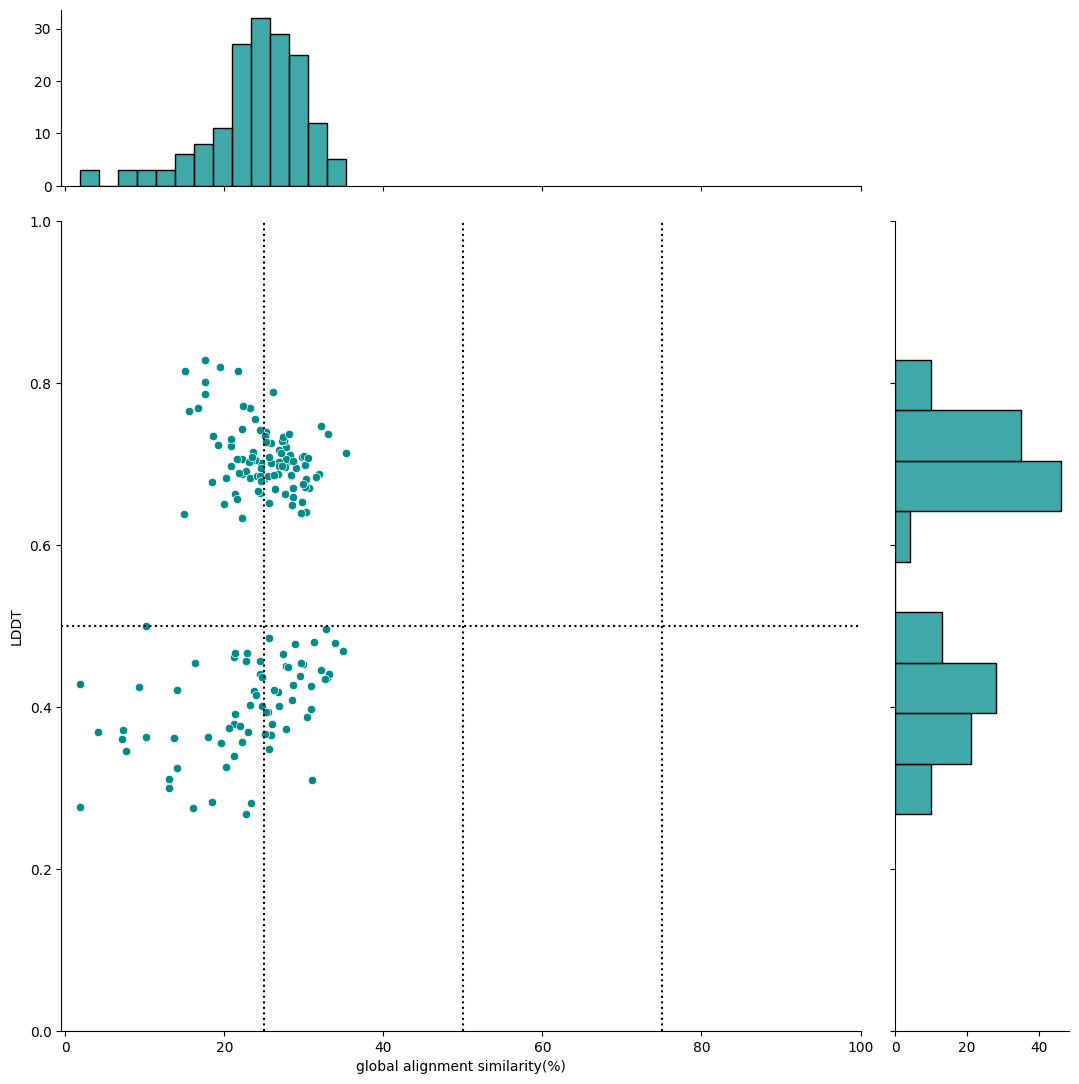

<Figure size 5000x5000 with 0 Axes>

In [19]:
foldseek_filter_viz_pd = foldseek_filter_viz.to_pandas()
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=foldseek_filter_viz_pd,
    x="Similarity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

# highlight the region of interest
# plt.fill_betweenx(
#     y=[0.5, 1],
#     x1=-0.5,
#     x2=25,
#     color="red",
#     alpha=0.1
# )

plt.xlim(-0.5,100)
plt.ylim(0,1)
plt.xlabel("global alignment similarity(%)")
plt.ylabel("LDDT")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

&nbsp;

&nbsp;
